![image](https://i.pinimg.com/originals/c9/2f/c9/c92fc9abdcb11028dd0448d36c580f83.jpg)


Key Features :
> * TPU as the accelerator
* Efficient Architecture
* EfficientNetB3 as a base model
* Tensorflow's Data Augmentation
* Focal Loss and Label Smoothening
* Bilinear Layer
* F1 Score
* 'imagenet' and 'noisy-student' as weights
* Stratified K-fold Cross-Validation
* Test Time Augmentation (TTA)

In [1]:
!pip install -q efficientnet

# Loading Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn
import random
import plotly.express as px
import plotly.graph_objects as go
import hashlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import model_from_json, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Convolution2D,Activation,MaxPooling2D,Flatten,Dense,Dropout,Input,Reshape,Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

# Setup

## Seeding

* If one wants to generate a sequence of random numbers and then be able to reproduce that same sequence of random numbers later one can set the random number seed generator with set.seed(). This is a critical aspect of reproducible research.

In [3]:
def seed_everything(seed=13):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_KERAS'] = '1'
    random.seed(seed)
    
seed_everything(42)

* TPU expedites the ability of training speed. For more, you can have a look at this [documentation.](https://www.kaggle.com/docs/tpu)

## TPU Configuration

In [4]:
def TPU():
    # Detect hardware, return appropriate distribution strategy
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return strategy


strategy = TPU()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


* load input path by means of TPU

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
IMG_SIZE_h = 512 
IMG_SIZE_w = 512
FOLDS = 5
SEED = 42
EPOCHS = 50
BATCH_SIZE = 8*strategy.num_replicas_in_sync

# Path Delineation

In [7]:
#Data Items
path='../input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(path+'train.csv')
train_id = train['image_id']
train.pop('image_id')

y_train = train.to_numpy().astype('float32')
category_names = ['healthy','multiple_diseases','rust','scab']
root = 'images'

images_paths = [(os.path.join(GCS_DS_PATH,root,idee+'.jpg')) for idee in train_id]

In [8]:
DIR_INPUT = '/kaggle/input/plant-pathology-2020-fgvc7'
train_df = pd.read_csv(DIR_INPUT + '/train.csv')
test_df = pd.read_csv(DIR_INPUT + '/test.csv')
cols = list(train_df.columns[1:])

train_paths = train_df['image_id'].apply(lambda x: os.path.join(GCS_DS_PATH , 'images' , x + '.jpg')).values
test_paths = test_df['image_id'].apply(lambda x: os.path.join(GCS_DS_PATH , 'images' , x + '.jpg')).values

train_labels = train_df.iloc[:,1:].values

# Exploratory Data Analysis (EDA)

In [9]:
(len(train_df), len(test_df))

(1821, 1821)

* It seems like both(train and test) data frames have the same size, but how different categories contribute in the training dataset?

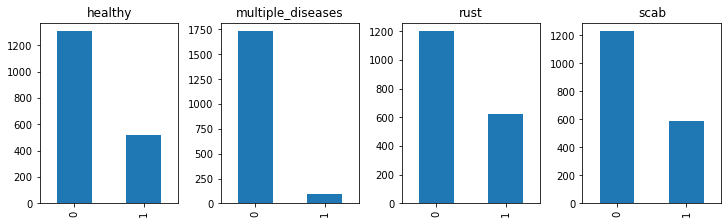

In [10]:
LABEL_COLS = ['healthy', 'multiple_diseases', 'rust', 'scab']

_, axes = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))
for ax, column in zip(axes, LABEL_COLS):
    train_df[column].value_counts().plot.bar(title=column, ax=ax)
plt.show()

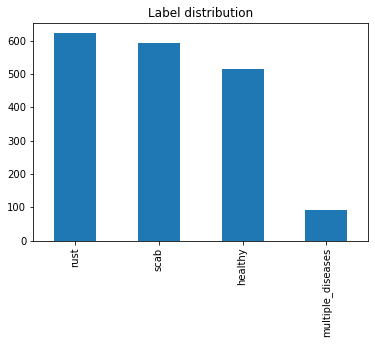

In [11]:
plt.title('Label distribution')
train_df[LABEL_COLS].idxmax(axis=1).value_counts().plot.bar()

Let's see how many times the labels appear together.

In [12]:
train_df.iloc[:,1:-1].sum(axis=1).value_counts()

1    1229
0     592
dtype: int64

In [13]:
train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].sum(axis=1).unique()

array([1])

Looks like never. So this appears to be multiclass but not multilabel classification. I copied few code fragments from this well-articulated [EDA Notebook](https://www.kaggle.com/pestipeti/eda-plant-pathology-2020). From where I got several insights that will unravel whether I should use k-fold or stratified k-fold cross fold and whether there are any noisy/duplicate images or not.

## Image Metadata

In [14]:
def calculate_hash(im):
    md5 = hashlib.md5()
    md5.update(np.array(im).tostring())
    
    return md5.hexdigest()
    
def get_image_meta(image_id, image_src, dataset='train'):
    im = Image.open(image_src)
    extrema = im.getextrema()

    meta = {
        'image_id': image_id,
        'dataset': dataset,
        'hash': calculate_hash(im),
        'r_min': extrema[0][0],
        'r_max': extrema[0][1],
        'g_min': extrema[1][0],
        'g_max': extrema[1][1],
        'b_min': extrema[2][0],
        'b_max': extrema[2][1],
        'height': im.size[0],
        'width': im.size[1],
        'format': im.format,
        'mode': im.mode
    }
    return meta

In [15]:
data = []

for i, image_id in enumerate(tqdm(train_df['image_id'].values, total=train_df.shape[0])):
    data.append(get_image_meta(image_id, DIR_INPUT + '/images/{}.jpg'.format(image_id)))

In [16]:
for i, image_id in enumerate(tqdm(test_df['image_id'].values, total=test_df.shape[0])):
    data.append(get_image_meta(image_id, DIR_INPUT + '/images/{}.jpg'.format(image_id), 'test'))

In [17]:
meta_df = pd.DataFrame(data)
meta_df.head()

image_id dataset                              hash  r_min  r_max  g_min  \
0  Train_0   train  0ed246432c166ea6b26ab531a0e14654     15    252     14   
1  Train_1   train  f2c4f0f0f3574c1722105635fb29d2ff     39    255     22   
2  Train_2   train  1ff49f8cd108961f3313eb8214195386     17    255     34   
3  Train_3   train  855994deab78d03bf29de8746eb84cda     18    255     26   
4  Train_4   train  3b8877a0a32112001c6e405131aab4f3     18    238     46   

   g_max  b_min  b_max  height  width format mode  
0    255      0    255    2048   1365   JPEG  RGB  
1    255      0    255    2048   1365   JPEG  RGB  
2    255      6    255    2048   1365   JPEG  RGB  
3    255      0    255    2048   1365   JPEG  RGB  
4    255      0    250    2048   1365   JPEG  RGB

## Image Orientations

It looks like we have both portrait and landscape modes in the train and the test set as well. The image size is always 2048x1368px (or 1365x2048).

In [18]:
meta_df.groupby(by='dataset')[['width', 'height']].aggregate(['min', 'max'])

width       height      
          min   max    min   max
dataset                         
test     1365  2048   1365  2048
train    1365  2048   1365  2048

* I will resize the image later.

## Duplications
We have a few duplications:

* train Train_379 and Train_1173
* test Test_683 and Test_1691
* test Test_570 and Test_1212
* mixed Train_1703 and Test_1407
* mixed Train_1505 and Test_829

In [19]:
duplicates = meta_df.groupby(by='hash')[['image_id']].count().reset_index()
duplicates = duplicates[duplicates['image_id'] > 1]
duplicates.reset_index(drop=True, inplace=True)

duplicates = duplicates.merge(meta_df[['image_id', 'hash']], on='hash')

duplicates.head(20)

hash  image_id_x  image_id_y
0  39cdbff63bcd5ec83cbf4e2f6147eb12           2  Train_1703
1  39cdbff63bcd5ec83cbf4e2f6147eb12           2   Test_1407
2  53e14328863405b825081244e44f16b3           2    Test_570
3  53e14328863405b825081244e44f16b3           2   Test_1212
4  a2570beaaaf16d50f7caecd7c7d51976           2    Test_683
5  a2570beaaaf16d50f7caecd7c7d51976           2   Test_1691
6  aeb03a2a591c5ec0646d71f585aa1d4d           2  Train_1505
7  aeb03a2a591c5ec0646d71f585aa1d4d           2    Test_829
8  de57848ea38eaa59ac8a2b417620084a           2   Train_379
9  de57848ea38eaa59ac8a2b417620084a           2  Train_1173

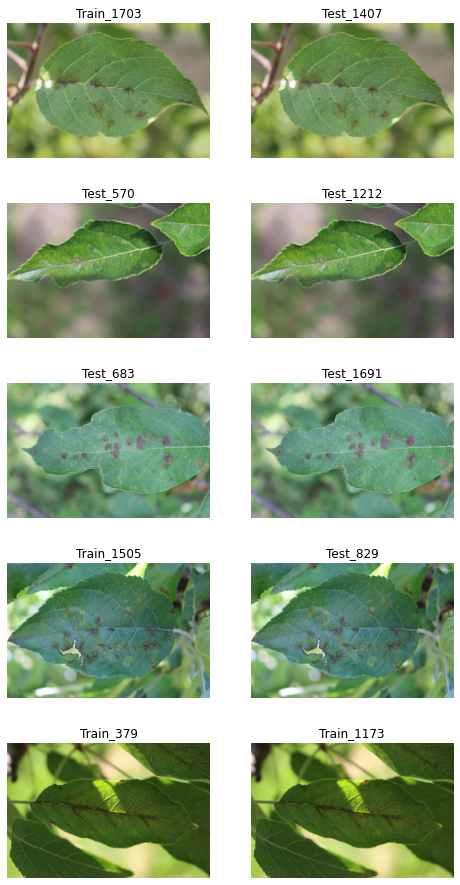

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(8, 16))
ax = ax.flatten()

for i in range(0, min(duplicates.shape[0], 10), 2):
    image_i = cv2.imread(DIR_INPUT + '/images/{}.jpg'.format(duplicates.iloc[i, 2]), cv2.IMREAD_COLOR)
    image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
    ax[i].set_axis_off()
    ax[i].imshow(image_i)
    ax[i].set_title(duplicates.iloc[i, 2])
    
    image_i_1 = cv2.imread(DIR_INPUT + '/images/{}.jpg'.format(duplicates.iloc[i + 1, 2]), cv2.IMREAD_COLOR)
    image_i_1 = cv2.cvtColor(image_i_1, cv2.COLOR_BGR2RGB)
    ax[i + 1].set_axis_off()
    ax[i + 1].imshow(image_i_1)
    ax[i + 1].set_title(duplicates.iloc[i + 1, 2])

* The image is the same. I must use Cross-Validation; otherwise, overfitting may occur.

## Target Distribution

In [21]:
def show_images(image_ids):
    
    col = 5
    row = min(len(image_ids) // col, 5)
    
    fig, ax = plt.subplots(row, col, figsize=(16, 8))
    ax = ax.flatten()

    for i, image_id in enumerate(image_ids):
        image = cv2.imread(DIR_INPUT + '/images/{}.jpg'.format(image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_axis_off()
        ax[i].imshow(image)
        ax[i].set_title(image_id)

In [22]:
fig = go.Figure(data=[
    go.Pie(labels=train_df.columns[1:],
           values=train_df.iloc[:, 1:].sum().values)
])
fig.show()

* As the label distribution is not the same, I must use stratified k-fold cross-validation

## Random Images

### from train

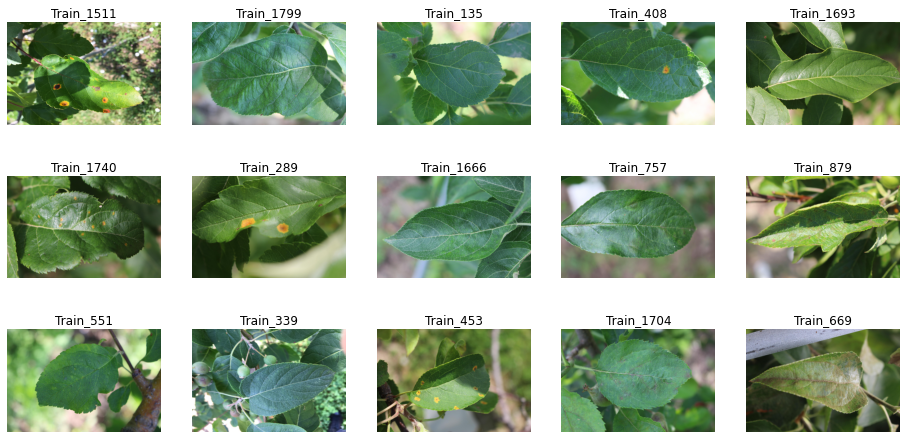

In [23]:
show_images(train_df.sample(n=15)['image_id'].values)

### from test

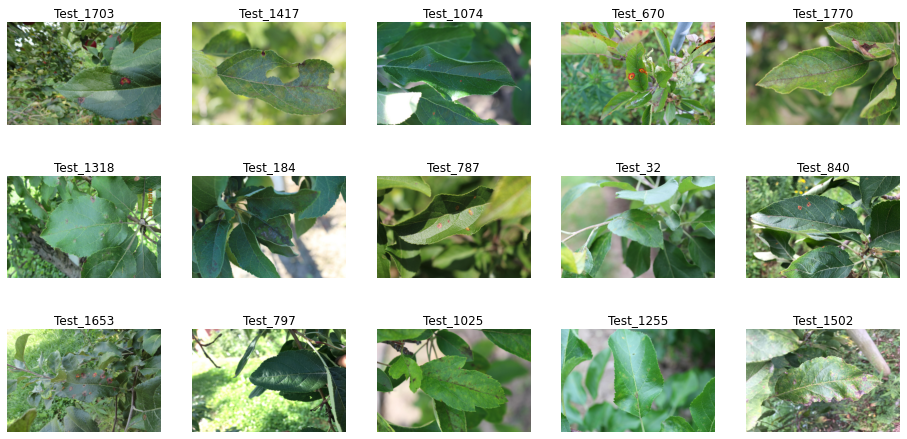

In [24]:
show_images(test_df.sample(n=15)['image_id'].values)

## Healthy Images

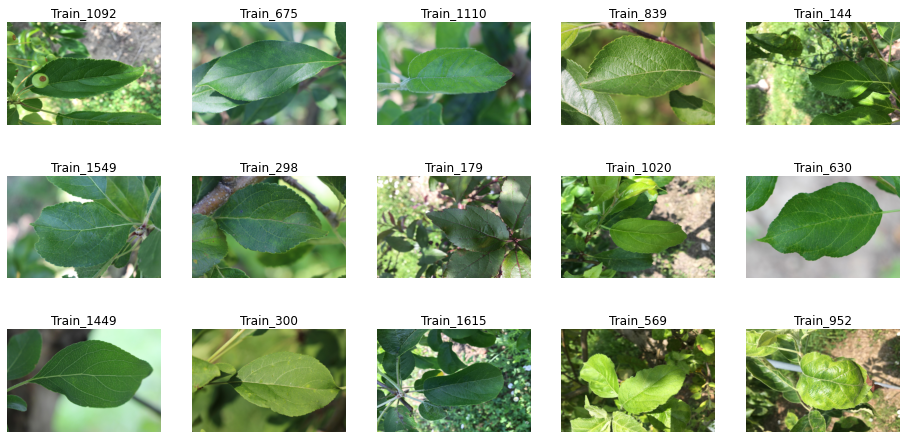

In [25]:
show_images(train_df[train_df['healthy'] == 1].sample(n=15)['image_id'].values)

## Infected with Rust

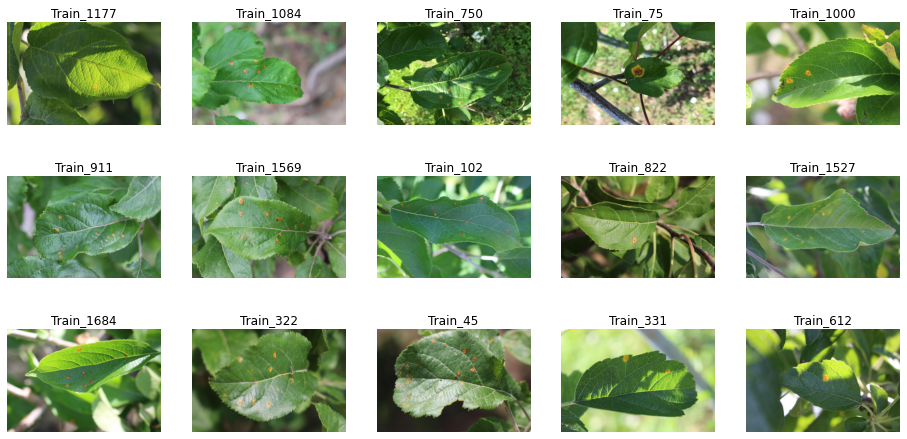

In [26]:
show_images(train_df[train_df['rust'] == 1].sample(n=15)['image_id'].values)

## Have Scab

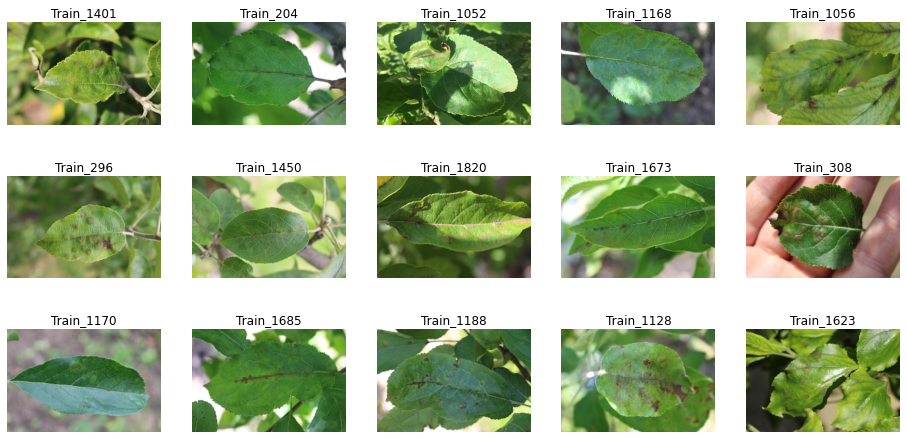

In [27]:
show_images(train_df[train_df['scab'] == 1].sample(n=15)['image_id'].values)

## Multiple Diseases

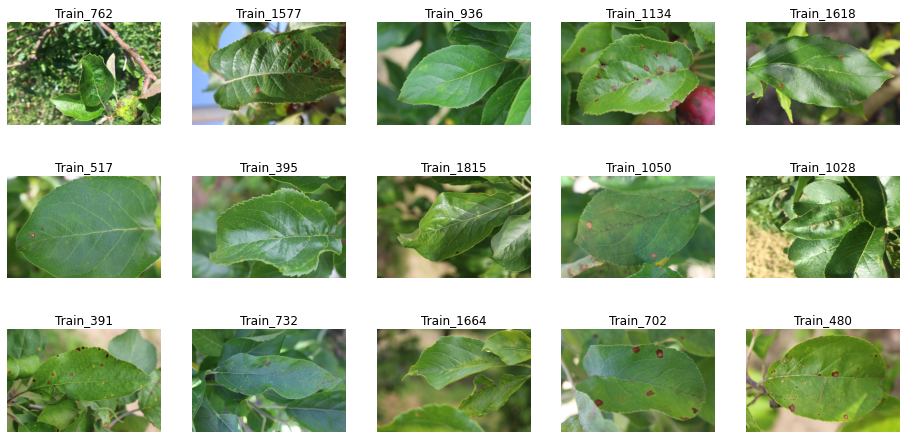

In [28]:
show_images(train_df[train_df['multiple_diseases'] == 1].sample(n=15)['image_id'].values)

# Define Needed Functions

In [29]:
def prepare_train(train_paths, train_labels):
    data = (
        tf.data.Dataset
        .from_tensor_slices((train_paths, train_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(512)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    return data

def prepare_val(val_paths, val_labels):
    data = (
        tf.data.Dataset
        .from_tensor_slices((val_paths, val_labels))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    return data

def prepare_test(test_paths):
    data = (
        tf.data.Dataset
        .from_tensor_slices((test_paths))
        .map(decode_image, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
    )
    return data

In [30]:
def decode_image(filename, label=None, image_size=(IMG_SIZE_h, IMG_SIZE_w)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    #convert to numpy and do some cv2 staff mb?
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=5050):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_crop(image,size=[IMG_SIZE_h,IMG_SIZE_w,3],seed=seed )
    image = tf.image.random_brightness(image,max_delta=0.5, seed=seed )
           
    if label is None:
        return image
    else:
        return image, label

* To know what I've done in the following four cells, you might read this awesome [notebook](https://www.kaggle.com/jimitshah777/bilinear-efficientnet-focal-loss-label-smoothing)

#### i)Focal Loss + Label Smoothing

In [31]:
def categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25,ls=0.1,classes=4.0):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
        y_ls = (1 - α) * y_hot + α / classes
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
        ls    -- label smoothing parameter(alpha)
        classes     -- No. of classes
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
        ls    -- 0.1
        classes     -- 4
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        #label smoothing
        y_pred_ls = (1 - ls) * y_pred + ls / classes
        # Clip the prediction value
        y_pred_ls = K.clip(y_pred_ls, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred_ls)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred_ls), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

#### ii) BiLinear Layer (outer_product())

In [32]:
def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

#### iii)F1 Score

In [33]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Denoting My Base Model

![image](https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png)

* I'm going to use the efficient net as I said earlier. As the accuracies of base models provided by EfficientNet architecture are much better in contrast with others, I'm going to use them accordingly.

In [34]:
def get_model():
    
    input_tensor = Input(shape=(IMG_SIZE_h,IMG_SIZE_w,3))
    
    model1 = efn.EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=(IMG_SIZE_h, IMG_SIZE_w, 3))
    model2 = efn.EfficientNetB3(weights='noisy-student', include_top=False, input_tensor=input_tensor,input_shape=(IMG_SIZE_h, IMG_SIZE_w, 3))
    
    for i, layer in enumerate(model1.layers):
        layer._name = 'model1_' + layer.name

    last_layer1 = model1.get_layer('model1_top_conv')
    last_output1 = last_layer1.output

    for i, layer in enumerate(model2.layers):
        layer._name = 'model2_' + layer.name

    last_layer2 = model2.get_layer('model2_top_conv')
    last_output2 = last_layer2.output
    
    
    model1_ = Model(inputs=model1.input, outputs=last_output1)
    model2_ = Model(inputs=model2.input, outputs=last_output2)
   
    
    model1_.compile(Adam(lr=0.0003, decay=1e-3),loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=4.0))
    model2_.compile(Adam(lr=0.0003, decay=1e-3),loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=4.0))
    
    d1=model1_.output
    d2=model2_.output

    bilinear = Lambda(outer_product, name='outer_product1')([d1,d2])
    
    predictions=Dense(4, activation='softmax', name='predictions')(bilinear)
    model = Model(inputs=model1.input, outputs=predictions)
    
    opt = Adam(lr=0.0003, decay=1e-3)
    model.compile(optimizer=opt, loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=4.0),metrics=[f1,'categorical_accuracy'])

    return model

In [35]:
def Callbacks():
    erl = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', 
                        restore_best_weights=True)
    rdc = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min')
    return [erl,rdc]

# Training

In [36]:
%%time

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
test_pred = []
val_roc_auc = []

for i, (train_idx, val_idx) in enumerate(skf.split(train_paths, train_labels.argmax(1))):
    print(); print('#'*25)
    print('###      FOLD',i+1)
    print('#'*25)
    X_train, X_val = train_paths[train_idx], train_paths[val_idx]
    y_train, y_val = train_labels[train_idx], train_labels[val_idx]
    
    strategy = TPU()
    with strategy.scope():
        model = get_model()
        history = model.fit(
                    prepare_train(X_train,y_train),
                    steps_per_epoch=y_train.shape[0] // BATCH_SIZE,
                    validation_data=prepare_val(X_val, y_val),
                    validation_steps=y_val.shape[0] // BATCH_SIZE,
                    callbacks=Callbacks(),
                    epochs=EPOCHS,
                    verbose=1
                )

    test_pred.append(model.predict(prepare_test(test_paths), verbose=1))
    val_roc_auc.append(roc_auc_score(y_val,model.predict(prepare_val(X_val, y_val), verbose=1)))


#########################
###      FOLD 1
#########################
Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
43933696/43933088 [==============================] - 1s 0us/step
Epoch 1/50
22/22 [==============================] - 77s 4s/step - categorical_accuracy: 0.6364 - loss: 0.3582 - f1: 0.3594 - val_categorical_accuracy: 0.6938 - val_loss: 0.3012 - val_f1: 0.6234 - lr: 3.0000e-04
Epoch 2/50
22/22 [==============================] - 41s 2s/step - categorical_accuracy: 0.9126 - loss: 0.0920 - f1: 0.9131 - val_categorical_accuracy: 0.8656 - val_loss: 0.1282 - val_f1: 0.8697 - lr: 3.0000e-04
Epoch 3/50
22/22 [==============================] - 40s 2s/step - categorical_accuracy: 0.9361 - loss: 0.0632 - f1: 0.9339 - val_categorical_accuracy: 0.9062 - val_loss: 0.1038 - val_f1: 0.9051 - lr: 3.0000e-04
Epoch 4/50
22/22 [==============================] - 38s 2s/step - categorical_accuracy: 0.9624 - loss: 0.0373 - f1: 0.9617 - val_categorical_accuracy: 0.9344 - val_loss: 0.0732 - val_

# Testing and Saving Model 

In [37]:
model_json = model.to_json()
with open("Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Model.h5")

In [38]:
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open('Model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Model.h5")
# loaded_model.summary()

In [39]:
val_roc_auc

[0.9968388264381639,
 0.9798895488583521,
 0.9600068777939326,
 0.9902614449701361,
 0.9702902916365352]

In [40]:
all_test = 0
for i in range(FOLDS):
    all_test += test_pred[i]

In [41]:
#If I want to predict on particular test_pred

#best_2_models = test_pred[0]*.7 + test_pred[3]*.3
#best_2_models

In [42]:
all_models = all_test/FOLDS
all_models

array([[9.9186692e-03, 2.5027025e-02, 9.6317512e-01, 1.8792578e-03],
       [1.7160384e-03, 1.8326866e-02, 9.7778749e-01, 2.1695648e-03],
       [4.7737793e-03, 1.0240048e-02, 7.4441259e-04, 9.8424178e-01],
       ...,
       [5.4036537e-03, 1.9245157e-02, 9.7416717e-01, 1.1839828e-03],
       [9.8254281e-01, 5.0956164e-03, 5.5352487e-03, 6.8263127e-03],
       [1.1756970e-02, 8.1419043e-02, 1.7397698e-03, 9.0508425e-01]],
      dtype=float32)

In [43]:
# best_2_models gives me better score on LB
sumb = pd.read_csv('../input/plant-pathology-2020-fgvc7/sample_submission.csv')
#sumb.iloc[:,1:] = best_2_models 
sumb.iloc[:,1:] = all_models
sumb.head()

image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.009919           0.025027  0.963175  0.001879
1   Test_1  0.001716           0.018327  0.977787  0.002170
2   Test_2  0.004774           0.010240  0.000744  0.984242
3   Test_3  0.977856           0.001307  0.005603  0.015234
4   Test_4  0.001982           0.014633  0.982557  0.000828

In [44]:
sumb.to_csv('submission.csv', index=False)
pd.Series(np.argmax(sumb[cols].values,axis=1)).value_counts()

2    733
3    590
0    383
1    115
dtype: int64

# Preprocess for TTA

In [45]:
def preprocess(df,test=False):
    paths = df.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values
    labels = df.loc[:,'healthy':].values
    if test==False:
        return paths,labels
    else:
        return paths

# Test Time Augmentation

In [46]:
TTA = 4

test_pred_tta = np.zeros((len(test_df),4))
for i in range(TTA):
    test_dataset_tta = (tf.data.Dataset
    .from_tensor_slices(preprocess(test_df,test=True))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)    
    .batch(BATCH_SIZE))
    test_pred_tta += model.predict(test_dataset_tta, verbose=1)
sumb = pd.read_csv(DIR_INPUT + '/sample_submission.csv')
sumb[['healthy', 'multiple_diseases', 'rust', 'scab']] = test_pred_tta/TTA
sumb.to_csv('submission_TTA.csv', index=False)
pd.Series(np.argmax(sumb[cols].values,axis=1)).value_counts()

29/29 [==============================] - 39s 1s/step


2    700
3    613
0    374
1    134
dtype: int64

In [47]:
sumb.head()

image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.001404           0.005582  0.992563  0.000451
1   Test_1  0.000578           0.008530  0.990595  0.000297
2   Test_2  0.003089           0.006329  0.000321  0.990261
3   Test_3  0.992058           0.000207  0.003211  0.004524
4   Test_4  0.000666           0.003536  0.995474  0.000323

# <font color='#774633'>I very much appreciate the time you spent on reading this notebook. Please let me know if I messed up anything. Thank You! 🙂 </font>